In [1]:
import math
import os
import gc
import sys
import time

from functools import partial
from typing import Dict, List, Optional, Tuple, Union

from numba import jit, njit
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')
# SAVE_DIR = os.path.join(BASE_DIR, 'data/dfdc-crops')
SAVE_DIR = '/media/dmitry/data/hdf5'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch
import torchvision

from torch import Tensor
from torchvision import ops

import nvidia.dali as dali
from nvidia.dali.plugin.pytorch import DALIGenericIterator

# src
sys.path.insert(0, SRC_DIR)
from sample.reader import VideoReader
from dataset.utils import read_labels

# Pytorch_Retinaface
sys.path.insert(0, os.path.join(BASE_DIR, 'Pytorch_Retinaface'))
from data import cfg_mnet
from layers.functions.prior_box import PriorBox
from models.retinaface import RetinaFace
from detect_utils import detect, load_model, postproc_detections, postproc_frame
from utils.nms.py_cpu_nms import py_cpu_nms

In [4]:
@njit
def calc_axis(c0, c1, pad, cmax):
    c0 = max(0, c0 - pad)
    c1 = min(cmax, c1 + pad)
    return c0, c1, c1 - c0


@njit
def expand_bbox(bbox, pct):
    bbox = np.copy(bbox)
    bbox[:2] *= 1 - pct
    bbox[2:] *= 1 + pct
    return bbox


@njit
def crop_face(img, bbox, pad_pct=0.05):
    img_h, img_w, _ = img.shape
    
    if pad_pct > 0:
        bbox = expand_bbox(bbox, pad_pct)
        
    x0, y0, x1, y1 = bbox.astype(np.int16)
    
    w, h = x1 - x0, y1 - y0
    if w > h:
        pad = (w - h) // 2
        y0, y1, h = calc_axis(y0, y1, pad, img_h)
    elif h > w:
        pad = (h - w) // 2
        x0, x1, w = calc_axis(x0, x1, pad, img_w)
    
    size = min(w, h)
    face = img[y0:y1, x0:x1][:size, :size]
    return face

In [5]:
def round_num_faces(num_faces, frac_thresh=0.25):
    avg = num_faces.mean()
    fraction, integral = np.modf(avg)
    rounded = integral if fraction < frac_thresh else integral + 1
    return int(rounded)

In [6]:
class VideoPipe(dali.pipeline.Pipeline):
    def __init__(self, file_list: str, seq_len=30, stride=10, 
                 batch_size=1, num_threads=1, device_id=0):
        super(VideoPipe, self).__init__(
            batch_size, num_threads, device_id, seed=3)
        
        self.input = dali.ops.VideoReader(
            device='gpu', file_list=file_list, sequence_length=seq_len, 
            stride=stride, shard_id=0, num_shards=1)

    def define_graph(self):
        output, labels = self.input(name='reader')
        return output, labels
    
    
def get_file_list(df: pd.DataFrame, start: int, end: int, 
                  base_dir: str =DATA_DIR) -> List[str]:
    path_fn = lambda row: os.path.join(base_dir, row.dir, row.name)
    return df.iloc[start:end].apply(path_fn, axis=1).values.tolist()


def write_file_list(files: List[str], path='./file_list.txt') -> None:    
    with open(path, mode='w') as h:
        for i, f in enumerate(files):
            h.write(f'{f} {i}\n')


def init_detector(cfg, weights, use_cpu=False):
    cfg['pretrain'] = False
    net = RetinaFace(cfg=cfg, phase='test')
    net = load_model(net, weights, use_cpu)
    net.eval()
    return net


def mkdirs(base_dir, chunk_dirs):
    for chunk_dir in chunk_dirs:
        dir_path = os.path.join(base_dir, chunk_dir)
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)

In [7]:
def prepare_imgs(sample: Union[np.ndarray, Tensor]) -> Tuple[Tensor, Tensor]:
    n, h, w, c = sample.shape
    mean = [104, 117, 123]
    if isinstance(sample, Tensor):
        imgs = sample.float()
        imgs -= torch.tensor(mean, device=imgs.device)
        imgs = imgs.permute(0, 3, 1, 2)
    else:
        imgs = np.float32(sample)
        imgs -= mean
        imgs = imgs.transpose(0, 3, 1, 2)
        imgs = torch.from_numpy(imgs)
    scale = torch.tensor([w, h, w, h])
    return imgs, scale


def detect(sample: Union[np.ndarray, Tensor], model: torch.nn.Module, 
           cfg: Dict[str,any], device: torch.device) -> List[np.ndarray]:
    bs = cfg['batch_size']
    num_frames, height, width, ch = sample.shape
    imgs, scale = prepare_imgs(sample)
    
    priorbox = PriorBox(cfg, image_size=(height, width))
    priors = priorbox.forward().to(device)
    scale = scale.to(device)
    detections = []
    
    for start in range(0, num_frames, bs):
        end = start + bs
        imgs_batch = imgs[start:end].to(device)
        with torch.no_grad():
            loc, conf, landms = model(imgs_batch)
        imgs_batch, landms = None, None
        dets = postproc_detections(loc, conf, priors, scale, cfg)
        detections.extend(dets)
        loc, conf = None, None
    return detections

In [8]:
def read_frames_cv2(path: str, num_frames: int, jitter=0, seed=None) -> np.ndarray:
    """Reads frames that are always evenly spaced throughout the video.

    Arguments:
        path: the video file
        num_frames: how many frames to read, -1 means the entire video
            (warning: this will take up a lot of memory!)
        jitter: if not 0, adds small random offsets to the frame indices;
            this is useful so we don't always land on even or odd frames
        seed: random seed for jittering; if you set this to a fixed value,
            you probably want to set it only on the first video 
    """
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0: 
        return None
    frame_idxs = np.linspace(0, frame_count - 1, num_frames, endpoint=True, dtype=np.int)
    if jitter > 0:
        np.random.seed(seed)
        jitter_offsets = np.random.randint(-jitter, jitter, len(frame_idxs))
        frame_idxs = np.clip(frame_idxs + jitter_offsets, 0, frame_count - 1)
    result = read_frames_at_indices(path, capture, frame_idxs)
    capture.release()
    return result


def read_frames_at_indices(
        path: str, capture: cv2.VideoCapture, frame_idxs: np.ndarray) -> np.ndarray:
    try:
        frames = []
        next_idx = 0
        for frame_idx in range(frame_idxs[0], frame_idxs[-1] + 1):
            ret = capture.grab()
            if not ret:
                print('Unable to grab frame %d from %s' % (frame_idx, path))
                break
            if frame_idx == frame_idxs[next_idx]:
                ret, frame = capture.retrieve()
                if not ret or frame is None:
                    print('Unable to retrieve frame %d from %s' % (frame_idx, path))
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
                next_idx += 1
        if len(frames) > 0:
            return np.stack(frames)
        else:
            print('No frames have been read from %s' % path)
            return None
    except Exception as e:
        print('Unable to read %s' % path)
        print(e)
        return None

In [9]:
import h5py

hdf5_defaults = dict(compression=6, shuffle=True)


def save_images_npz(path: str, images: List[np.ndarray]) -> None:
    file_map = {str(i):cv2.imencode('.png', image)[1] 
                for i,image in enumerate(images)}
    np.savez_compressed(path, **file_map)
    
    
def save_images_hdf5(path: str, images: List[np.ndarray], 
                     opts: dict = hdf5_defaults) -> None:
    with h5py.File(path, 'w') as file:  
        for i, image in enumerate(images):
            dataset = file.create_dataset(
                '%03d' % i, data=cv2.imencode('.png', image)[1], **opts)
    
    
def load_images_npz(path: str) -> List[np.ndarray]:
    images = []
    with np.load(path) as archive:
        for key in archive.keys():
            img = cv2.imdecode(archive[key], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images


def load_images_hdf5(path: str, num_frames=30) -> List[np.ndarray]:
    images = []
    with h5py.File(path, 'r+') as file:
        total_frames = len(file)
        pick = create_mask(num_frames, total_frames)
        for i, key in enumerate(file.keys()):
            if pick[i]:
                img = np.uint8(file[key])
                img = cv2.imdecode(img, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images


def calc_idxs(n: int, total: int) -> np.ndarray:
    idxs = np.linspace(0, total, n, dtype=int, endpoint=False)
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def create_mask(n: int, total: int) -> np.ndarray:
    mask = np.zeros(total, dtype=np.bool)
    idxs = calc_idxs(n, total)
    mask[idxs] = 1
    return mask


def frames_to_faces(frames: np.ndarray, detect_fn) -> None:
    detections = detect_fn(frames)
    if isinstance(frames, Tensor):
        frames = frames.cpu().numpy()
    num_faces = np.array(list(map(len, detections)), dtype=np.uint8)
    max_faces_per_frame = round_num_faces(num_faces, frac_thresh=0.25)
    faces = []
    for f in range(len(frames)):
        for det in detections[f][:max_faces_per_frame]:
            face = crop_face(frames[f], det[:4])
            face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
            faces.append(face)
    detections = None
    return faces


def dump_to_disk(images: List[np.ndarray], 
                 dir_path: str, filename: str) -> None:
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
    file_path = os.path.join(dir_path, filename+'.h5')
    save_images_hdf5(file_path, images)


def prepare_data(
        start=0, end=None, chunk_dirs=None, max_open_files=100, 
        file_list_path='./temp_files.txt', verbose=False,
        num_frames=30, stride=10, use_cpu=False, bs=32, 
        base_dir=BASE_DIR, data_dir=DATA_DIR, save_dir=SAVE_DIR):
    df = read_labels(data_dir, chunk_dirs=chunk_dirs)
    mkdirs(save_dir, df['dir'].unique())
    
    device = torch.device("cpu" if use_cpu else "cuda")
    weights_mnet = os.path.join(base_dir, 'data/weights/mobilenet0.25_Final.pth')
    cfg = {**cfg_mnet, 'batch_size': bs}
    detector = init_detector(cfg, weights_mnet, use_cpu).to(device)
    detect_fn = partial(detect, model=detector, cfg=cfg, device=device)
    
    if end is None:
        end = len(df)
    
    for start_pos in range(start, end, max_open_files):
        end_pos = min(start_pos + max_open_files, end)
        files = get_file_list(df, start_pos, end_pos)
        write_file_list(files, path=file_list_path)
        pipe = VideoPipe(file_list_path, seq_len=num_frames, stride=stride)
        pipe.build()
        num_samples = len(files)
        num_samples_read = pipe.epoch_size('reader')
        num_bad_samples = num_samples - num_samples_read
        run_fallback_reader = num_bad_samples > 0
        if run_fallback_reader:
            print('Unable to parse %d videos with DALI' % num_bad_samples)
            proc_file_idxs = np.zeros(num_samples, dtype=np.bool)
            
        if num_samples_read > 0:
            data_iter = DALIGenericIterator(
                [pipe], ['frames', 'label'], num_samples_read, dynamic_shape=True)
            if verbose: 
                t0 = time.time()
            for idx, video_batch in tqdm(enumerate(data_iter), total=num_samples_read):
                frames = video_batch[0]['frames'].squeeze(0)
                read_idx =  video_batch[0]['label'].item()
                abs_idx = start_pos + read_idx
                meta = df.iloc[abs_idx]
                faces = frames_to_faces(frames, detect_fn)
                dump_to_disk(faces, os.path.join(save_dir, meta.dir), meta.name[:-4])
                if run_fallback_reader:
                    proc_file_idxs[read_idx] = True
                if verbose:
                    t1 = time.time()
                    print('[%6d][%.02f s] %s/%s' % (abs_idx, t1 - t0, meta.dir, meta.name))
                    t0 = t1
                    
        pipe, data_iter = None, None
        gc.collect()
        
        if run_fallback_reader:
            print('Running fallback decoding through OpenCV...')
            unproc_file_idxs = (~proc_file_idxs).nonzero()[0]
            for idx in tqdm(unproc_file_idxs):
                if verbose: 
                    t0 = time.time()
                frames = read_frames_cv2(files[idx], num_frames)
                abs_idx = start_pos + idx
                meta = df.iloc[abs_idx]
                faces = frames_to_faces(frames, detect_fn)
                dump_to_disk(faces, os.path.join(save_dir, meta.dir), meta.name[:-4])
                if verbose:
                    t1 = time.time()
                    print('[%6d][%.02f s] %s/%s' % (abs_idx, t1 - t0, meta.dir, meta.name))
    print('DONE')

In [10]:
%%time
gc.collect()
prepare_data(start=0, end=10, max_open_files=300, bs=30, 
             num_frames=30, stride=10, 
             verbose=True, chunk_dirs=['dfdc_train_part_3'])

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


[     0][0.94 s] dfdc_train_part_3/vngueqqcmz.mp4
[     1][0.75 s] dfdc_train_part_3/ieblyetiob.mp4
[     2][0.61 s] dfdc_train_part_3/dnrpknwija.mp4
[     3][0.60 s] dfdc_train_part_3/zznanrtksj.mp4
[     4][0.57 s] dfdc_train_part_3/vdwoazrodt.mp4
[     5][0.60 s] dfdc_train_part_3/znnqbkpanr.mp4
[     6][0.77 s] dfdc_train_part_3/cxwcpgspni.mp4
[     7][0.73 s] dfdc_train_part_3/lkazyduuwz.mp4
[     8][0.68 s] dfdc_train_part_3/ldefmlfcdg.mp4
[     9][0.66 s] dfdc_train_part_3/khmeblwrds.mp4

DONE
CPU times: user 6.92 s, sys: 1.76 s, total: 8.68 s
Wall time: 10.1 s


In [21]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

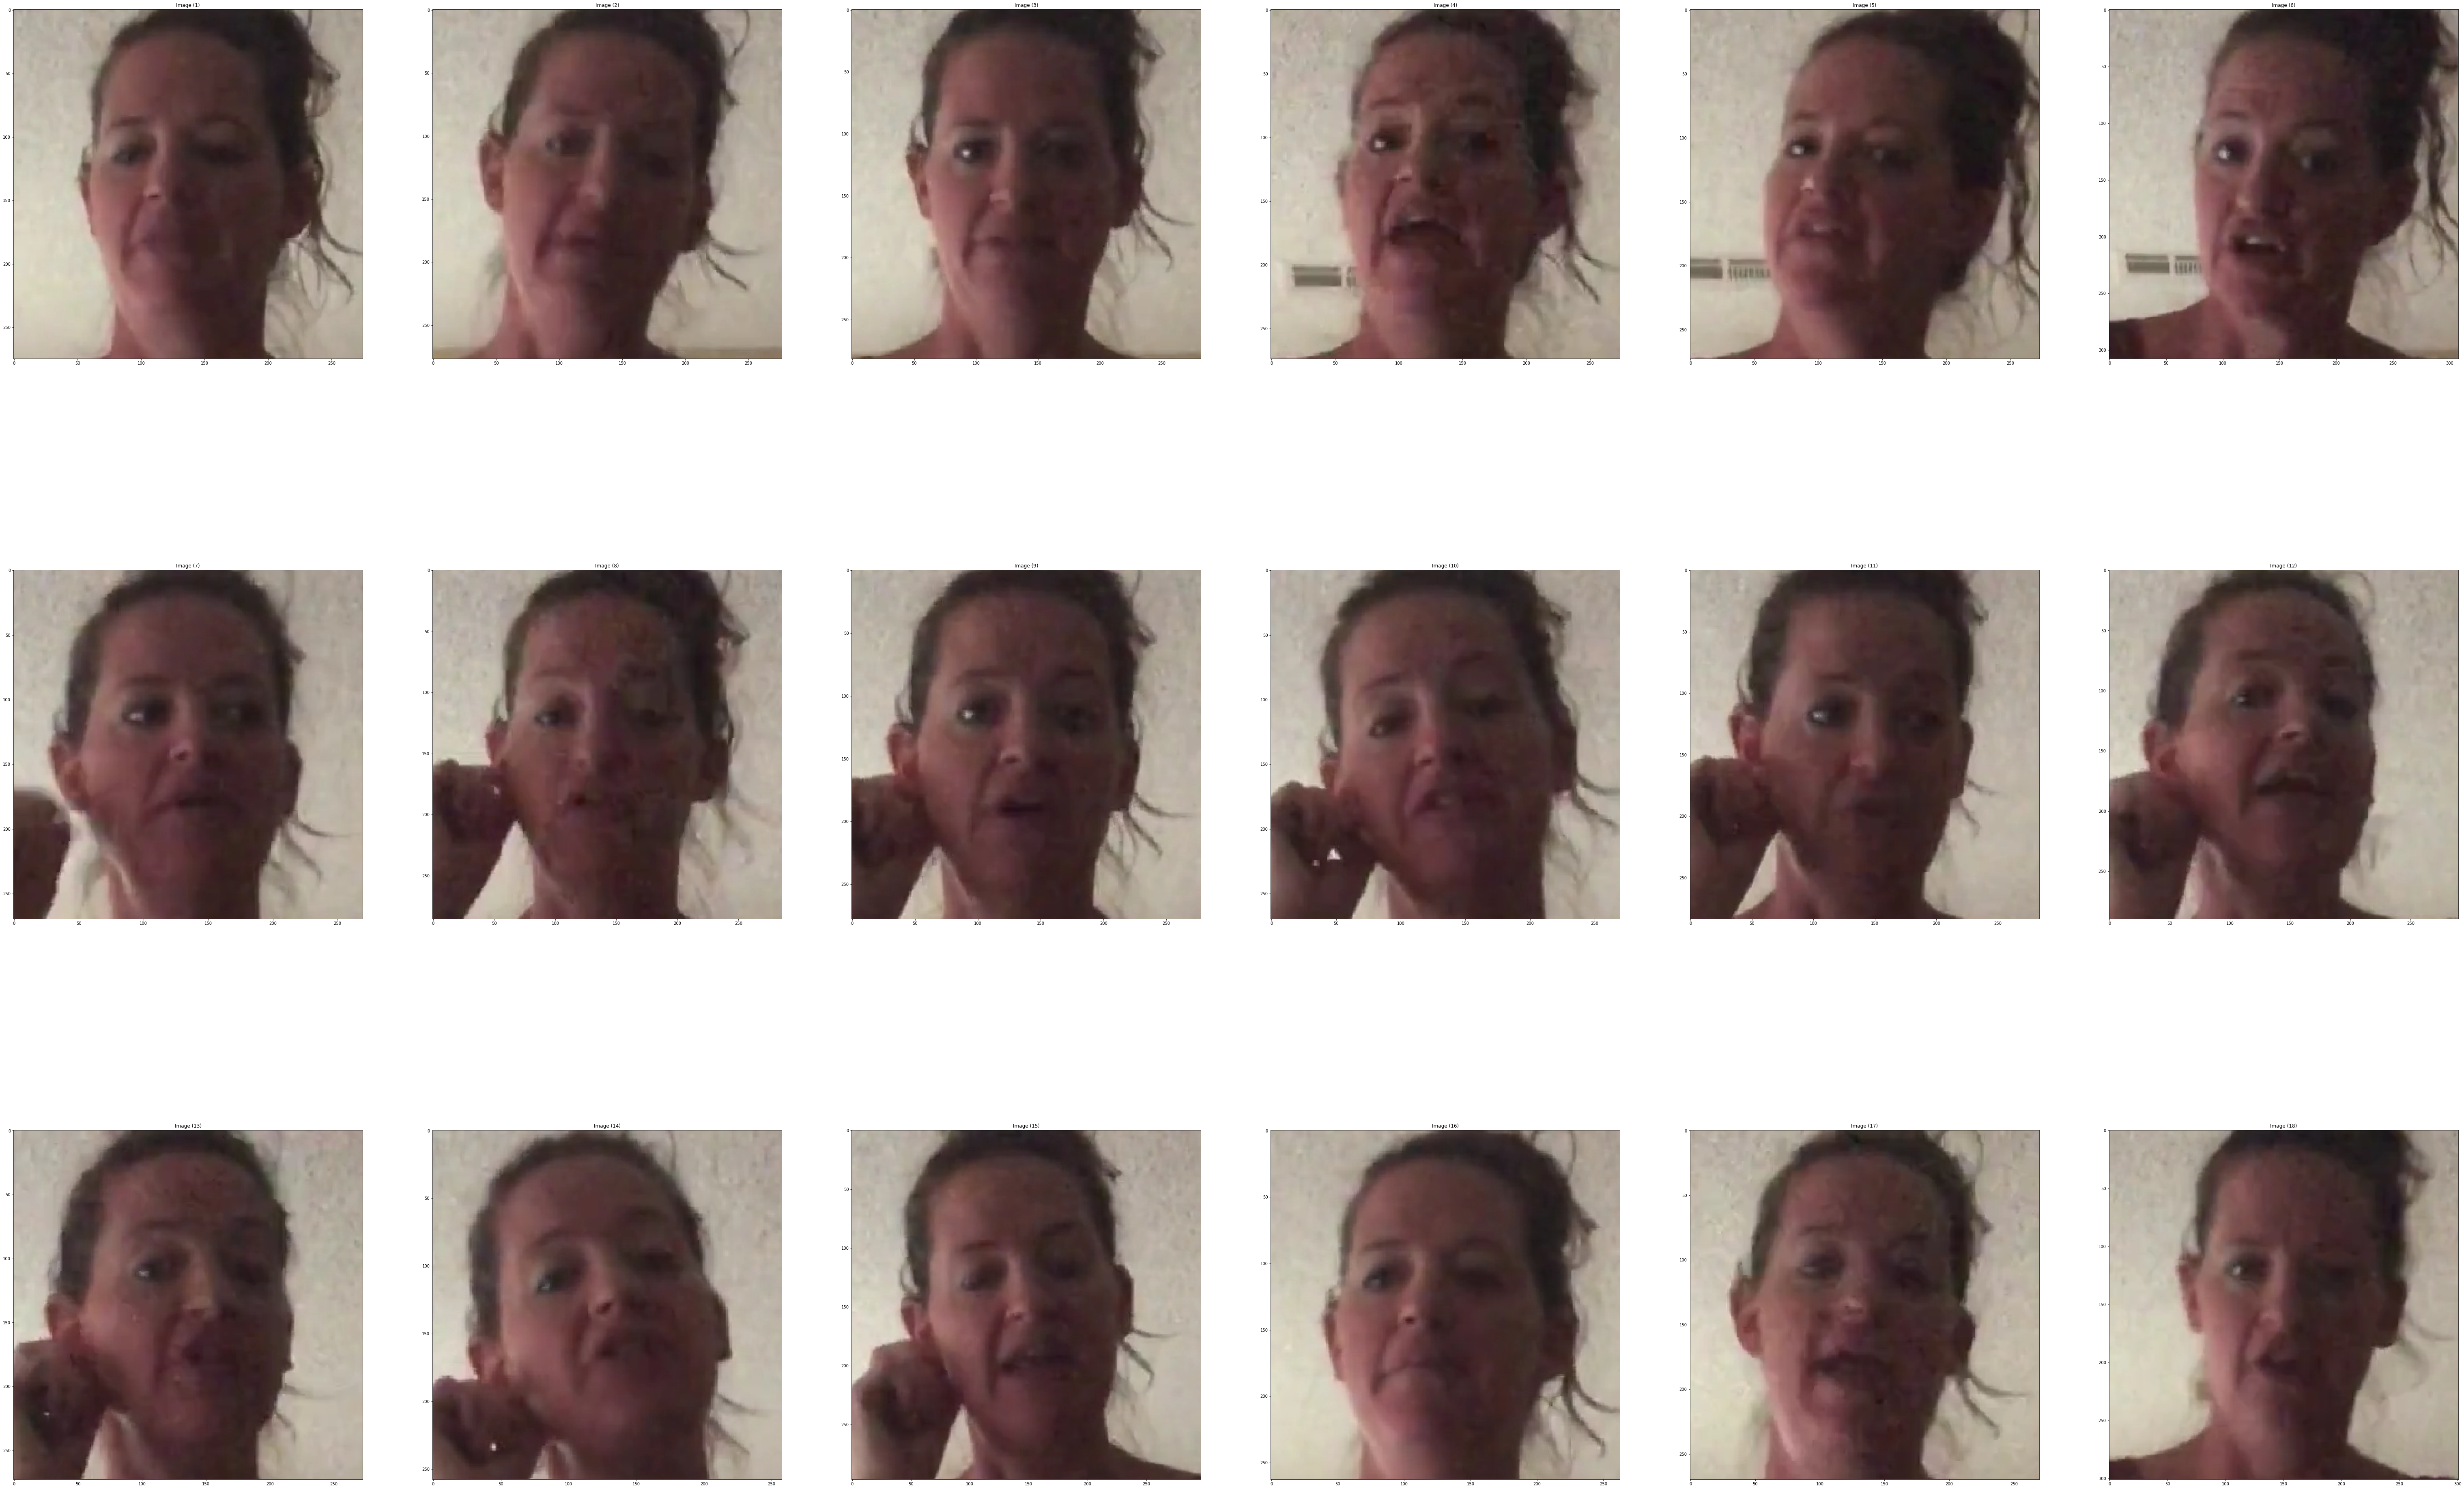

In [26]:
path = '/media/dmitry/data/hdf5/dfdc_train_part_3/cxwcpgspni.h5'
num_frames = 18
cols = math.ceil(num_frames / 6)
faces = load_images_hdf5(path, num_frames=num_frames)        
show_images(faces, cols=cols)

In [13]:
# path = '/media/dmitry/data/dfdc_train_part_2/jsnkotxoua.h5.npz'
# faces = load_images_from_npz(path)        
# show_images(faces, cols=5)

In [15]:
# def bench(path, read_fn):
#     for name in os.listdir(path):
#         full_path = os.path.join(path, name)
#         if os.path.isfile(full_path):
#             read_fn(full_path)

In [16]:
# %%time
# bench('/media/dmitry/data/npz/dfdc_train_part_2', load_images_npz)

In [17]:
# %%time
# bench('/media/dmitry/data/hdf5/dfdc_train_part_2', 
#       partial(load_images_hdf5, num_frames=50))

In [18]:
# %%time
# bench('/home/dmitry/projects/dfdc/data/npz/dfdc_train_part_2', load_images_npz)

In [19]:
# %%time
# bench('/home/dmitry/projects/dfdc/data/hdf5/dfdc_train_part_2', 
#       partial(load_images_hdf5, num_frames=30))